<a href="https://colab.research.google.com/github/Nag-Nad/Machine-Learning-in-Chemistry/blob/main/TEST1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 31.2 MB/s eta 0:00:00


In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdDepictor
from rdkit.Chem.rdDepictor import Compute2DCoords
import glob
import pandas as pd

In [ ]:
# Merge csv files into one dataframe using glob library

csv_files = glob.glob('/content/drive/MyDrive/Colab Notebooks/**/*.csv', recursive=True)
data = pd.DataFrame()
data = pd.concat([pd.read_csv(files) for files in csv_files], ignore_index = True)
data

,zinc_id,smiles
0,ZINC000000001084,Cn1c(=O)c2c(ncn2C)n(C)c1=O
1,ZINC000000033882,NCCc1ccc(O)c(O)c1
2,ZINC000000001411,C=CCc1ccc(O)c(OC)c1
3,ZINC000001482164,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O
4,ZINC000001532517,CC(=O)C(=O)O


In [ ]:
# Add a new column to the dataframe at the location 0
molecules = ['Ice', 'Dopamine', 'Eugenol', 'Caffeine', 'Pyruvate']
data.insert(0, 'Molecules', molecules)
data

,Molecules,zinc_id,smiles
0,Ice,ZINC000000001084,Cn1c(=O)c2c(ncn2C)n(C)c1=O
1,Dopamine,ZINC000000033882,NCCc1ccc(O)c(O)c1
2,Eugenol,ZINC000000001411,C=CCc1ccc(O)c(OC)c1
3,Caffeine,ZINC000001482164,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O
4,Pyruvate,ZINC000001532517,CC(=O)C(=O)O


In [ ]:
# Calculate the Molecular Weight
data['MolWt'] = data['smiles'].apply(lambda smiles: Chem.Descriptors.MolWt(Chem.MolFromSmiles(smiles))
if Chem.MolFromSmiles(smiles) else None)

# Calculate the number of heavy atoms
data['HeavyAtoms_number'] = data['smiles'].apply(lambda smiles: Chem.Descriptors.HeavyAtomCount(Chem.MolFromSmiles(smiles))
if Chem.MolFromSmiles(smiles) else None)

# Calculate the number of rotatable bonds
data['Rotatable_bonds'] = data['smiles'].apply(lambda smiles: Chem.Descriptors.NumRotatableBonds(Chem.MolFromSmiles(smiles))
if Chem.MolFromSmiles(smiles) else None)

# Calculate logP
data['logP'] = data['smiles'].apply(lambda smiles: Chem.Descriptors.MolLogP(Chem.MolFromSmiles(smiles))
if Chem.MolFromSmiles(smiles) else None)

data

,Molecules,zinc_id,smiles,MolWt,HeavyAtoms_number,Rotatable_bonds,logP
0,Ice,ZINC000000001084,Cn1c(=O)c2c(ncn2C)n(C)c1=O,194.194,14,0,-1.0293
1,Dopamine,ZINC000000033882,NCCc1ccc(O)c(O)c1,153.181,11,2,0.5990
2,Eugenol,ZINC000000001411,C=CCc1ccc(O)c(OC)c1,164.204,12,3,2.1293
3,Caffeine,ZINC000001482164,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O,156.269,11,1,2.4395
4,Pyruvate,ZINC000001532517,CC(=O)C(=O)O,88.062,6,1,-0.3400


In [ ]:
# Apply the conditions:
'''
1. the molecular weight of molecules must be between 100-700 Da;
2. total number of atoms of each molecule must be less than or equal to 60;
3. number of rotatable bonds must be less than or equal to 15;
4. octonal-water coefficient (logP) must be less than or equal to 5.
'''

data = data.loc[(data['MolWt']<700) & (data['MolWt'] > 100) &
 (data['HeavyAtoms_number'] <= 60) & (data['Rotatable_bonds'] <= 15) &
  (data['logP'] <= 5)]

data

,Molecules,zinc_id,smiles,MolWt,HeavyAtoms_number,Rotatable_bonds,logP
0,Ice,ZINC000000001084,Cn1c(=O)c2c(ncn2C)n(C)c1=O,194.194,14,0,-1.0293
1,Dopamine,ZINC000000033882,NCCc1ccc(O)c(O)c1,153.181,11,2,0.5990
2,Eugenol,ZINC000000001411,C=CCc1ccc(O)c(OC)c1,164.204,12,3,2.1293
3,Caffeine,ZINC000001482164,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O,156.269,11,1,2.4395


In [45]:
# Convert SMILES to molecule objects
mol_list = []
for smiles in data['smiles']:
    mol = Chem.MolFromSmiles(smiles)
    mol_list.append(mol)

def calculate_tanimoto_coefficient(mol1, mol2):
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 3, nBits=2048)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 3, nBits=2048)
    tanimoto = DataStructs.TanimotoSimilarity(fp1, fp2)
    return tanimoto

# Create a similarity matrix DataFrame
similarity_matrix = pd.DataFrame(index=data['Molecules'], columns=data['Molecules'])

# Calculate Tanimoto similarity for each pair of molecules
for i in range(len(mol_list)):
    for j in range(i, len(mol_list)):
        mol1 = mol_list[i]
        mol2 = mol_list[j]
        tanimoto_coefficient = calculate_tanimoto_coefficient(mol1, mol2)
        similarity_matrix.iat[i, j] = tanimoto_coefficient
        similarity_matrix.iat[j, i] = tanimoto_coefficient

similarity_matrix = similarity_matrix.fillna(1.0)  # Fill None Values with 1.0

print(similarity_matrix)


Molecules       Ice  Dopamine   Eugenol  Caffeine
Molecules                                        
Ice        1.000000  0.033898  0.045455  0.016949
Dopamine   0.033898  1.000000  0.240000  0.039216
Eugenol    0.045455  0.240000  1.000000  0.051724
Caffeine   0.016949  0.039216  0.051724  1.000000


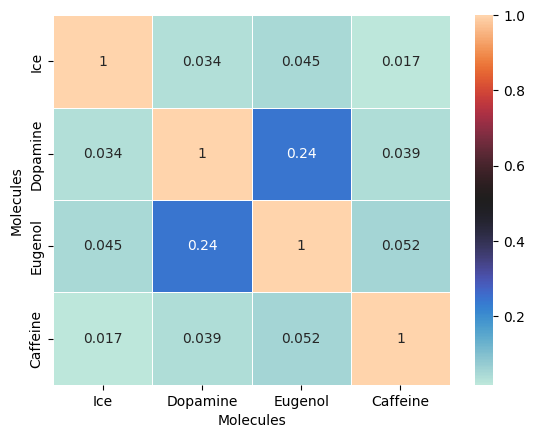

In [56]:
# heatmap: the color intensity the correlation between x and y

import seaborn as sns

heatmap = sns.heatmap(similarity_matrix, annot=True, linewidth=.5, cmap="icefire")

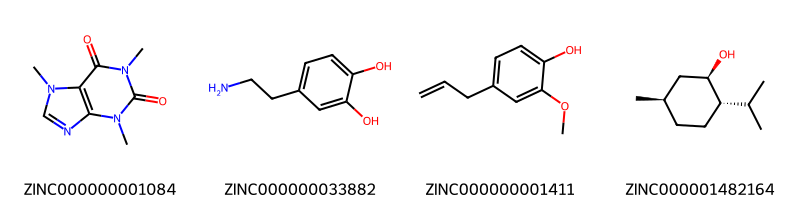

In [47]:
from rdkit.Chem import Draw

# Draw the 2D structure of moleules
mol_list = []
for smiles in data['smiles']:
  mol = Chem.MolFromSmiles(smiles)
  mol_list.append(mol)
# Put the name of the moleculles
img = Draw.MolsToGridImage(mol_list, molsPerRow= 4, useSVG=True, legends = list(data['zinc_id']))
img
